In [6]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy.signal as signal
import numpy as np

from IPython.display import Audio, display, HTML
from ipywidgets import interact

from scipy.io import wavfile
import requests

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "8,3"

import jupyter_tikz
%load_ext jupyter_tikz
# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


In [7]:
display(HTML("<style>.audiotable>tbody>tr>td { border: 1px solid; padding: 10px; }</style>"))

# Multipath Propagation and Multipath Channel

In this article, we will examine the effect of multipath propagation to a transmitted signal. Furthermore, we will illustrate the effect with the help of audio examples (*scroll down for the examples*). 

First, let's try to understand the transmission of a signal from a source $S$ to a destination $D$, which are $d$ meters apart:

In [8]:
%%tikz 
\draw [shorten >=0pt, shorten <=0pt,-stealth] (0,0) node (S) [left] {$S$} -- +(6,0) node (D) [right] {$D$};
\draw [<->] ([yshift=-3mm]S.east) -- ([yshift=-3mm]D.west) node [midway,below] {$d$ meters};

/bin/sh: 1: pdflatex: not found


If we assume, the signal travels with velocity $c$, it will take $\tau=\frac{d}{c}$ seconds until it arrives at the destination. Mathematically, we have

$$y(t)=x\left(t-\frac{d}{c}\right),$$

where $x(t)$ is the transmitted signal and $y(t)$ is the received signal. Now, we know that the signal from the source is not only transmitted into the direction of $D$, but in all directions. Let's assume somewhere around the source, there is a big wall that can reflect the signal:

In [9]:
%%tikz -l patterns
\draw [shorten >=0pt, shorten <=0pt,-stealth] (0,0) node (S) [left] {$S$} -- +(6,0) node (D) [right] {$D$};
\draw [<->] ([yshift=-3mm]S.east) -- ([yshift=-3mm]D.west) node [midway,below] {$d$ meters};

\draw [-stealth] (S.east) -- +(2,1) node [pos=0.4,yshift=2mm] {\rotatebox{25}{$d_1$ meters}};
\draw [-stealth] (S.east) +(2,1) -- (D.west) node [pos=0.6,yshift=2mm] {\rotatebox{-15}{$d_2$ meters}};
\draw [very thick] (1,1) -- (3,1);
\draw [draw=none,pattern=north east lines] (1,1) rectangle (3,1.1);

/bin/sh: 1: pdflatex: not found


So, at the destination we receive two copies of the signal: One over the path of $d$ meters and one over the path of $d_1$ + $d_2$ meters. Let us assume that the reflection of the signal at the wall removes 50% of the amplitude from the signal. Then, the received signal at the destination can be mathematically written as 

$$y(t)=x\left(t-\frac{d}{c}\right) + 0.5\cdot x\left(t-\frac{d_1+d_2}{c}\right).$$

This characteristic is named **multipath propagation**, since the signal can arrive at the destination via multiple different paths. We can express the received signal as a [convolution](http://dspillustrations.com/pages/posts/misc/convolution-examples-and-the-convolution-integral.html). Remember the time-shifting rule for the Dirac Delta function

$$a(t)*\delta(t-\tau) = a(t-\tau),$$

i.e. convolving a signal $a(t)$ with a time-shifted Dirac Delta amounts to a time-shift of the convolved signal $a(t-\tau)$. Using this property, we can express the received signal by

$$y(t) = x(t)*\left[\delta\left(t-\frac{d}{c}\right)+0.5\cdot\delta\left(t-\frac{d_1+d_2}{c}\right)\right].$$

If we replace $\tau_1=\frac{d}{c}$, $\tau_2=\frac{d_1+d_2}{c}$, $a_1=1$, $a_2=0.5$, we can write
$$y(t)=x(t)*\left[a_1\delta(t-\tau_1)+a_2\delta(t-\tau_2)\right].$$

In general, there can be more than 2 paths for the transmission, so we can generalize this formula to
$$y(t) =x(t)*\sum_{n=1}^{L}a_n\delta(t-\tau_n)=x(t)*h(t),$$
where $L$ denotes the number of paths, $a_n$ is the amplitude for this path and $\tau_n$ is the delay for this path. We can combine all multipaths into the function $h(t)$, which describes the impulse response of the system. 

Hence, the system is a linear timeinvariant (LTI) system, and vast mathematical analysis can be done on these types of systems. For now, let us just listen to the effect that multipath propagation has on an audio signal. You can imagine, it sounds like an echo in the mountains. 

First, let's load some audio files from the internet. We resample them to 10kHz sampling frequency to save some bandwidth and to have a common sampling rate. Here's a function which loads an audio file from the internet:

In [10]:
def loadAudio(url, start, length):
    R = requests.get(url)
    with open("sound.mp3", "wb") as f:
        f.write(R.content)
    !ffmpeg -y -i sound.mp3 sound.wav > /dev/null 2>&1
    rate, data = wavfile.read("sound.wav")
    if len(data.shape) > 1:
        data = data.sum(axis=1)
    data = (1.0 * data / abs(data).max()).astype(np.float32)
    
    dataPart = data[rate*start+np.arange(min(rate*length, len(data)))]
    targetRate = 10000   # Resample signal to 10kHz sampling rate
    assert (rate > targetRate)
    targetSamples = int(len(dataPart) * targetRate / rate)
    resampled = signal.resample(dataPart, targetSamples)
    return targetRate, resampled

Below is just some convenience function to show two audio samples side by side.

In [11]:
def audioSideBySide(name1, audio1, name2, audio2):
    text = "<table><tr><td>%s</td><td>%s</td></tr><tr><td>%s</td><td>%s</td></tr></table>" % (name1, name2, audio1._repr_html_(), audio2._repr_html_())
    display(HTML(text))

Now, let's load some sounds from the internet and listen to them:

In [12]:
url_voice = "http://ia800200.us.archive.org/21/items/adventures_of_dog_1101_librivox/adventuresofadog_00_elwes.mp3"
url_music = "http://www.scientificinvesting.eu/a/Mozart%20-%20Symphony%20n.10%20K.74%20in%20G%20-%201%20Allegro.mp3"
rate_voice, data_voice = loadAudio(url_voice, 40, 10)
rate_music, data_music = loadAudio(url_music, 40, 10)
rate_slap, data_slap = loadAudio("http://soundbible.com/grab.php?id=1948&type=mp3", 0, 2)
rate_morse, data_morse = loadAudio("http://soundbible.com/grab.php?id=1170&type=mp3", 0, 2)
rate = rate_slap

FileNotFoundError: [Errno 2] No such file or directory: 'sound.wav'

In [8]:
audioSideBySide("Slap", Audio(data=data_slap, rate=rate_slap), "Morse", Audio(data=data_morse, rate=rate_morse))
audioSideBySide("Music", Audio(data=data_music, rate=rate_music), "Voice", Audio(data=data_voice, rate=rate_voice))

Slap,Morse


Music,Voice


We have a short, impulse-like "slap" sound. We can use this sound to easily hear the different echos from the multipath transmission. Then, we have some signal of a morse code transmission. We will hear, that successful decoding is very hard, once there exists some multipath. Finally, we have voice and music samples to examine the effect of the multipath.

Let us define a function `visualizeMultipath` which calculates the effectice channel impulse response, given coordinates of source, destination and some reflectors. Additionally, it draws a diagram of the locations of the source, destination and reflectors.

In [9]:
c = 334  # Speed of sound in air
def visualizeMultipath(source, dest, reflectors):
    source = np.array(source); dest = np.array(dest);
    tau_list = []  # list of delays
    amp_list = [] # list of amplitudes
    plt.plot(source[0], source[1], 'x')
    plt.plot(dest[0], dest[1], 'o')
    plt.text(source[0], source[1], 'Source', ha='right', bbox=dict(facecolor='white'))
    plt.text(dest[0], dest[1], 'Destination', ha='left', bbox=dict(facecolor='white'))
    dist = np.linalg.norm(dest - source); 
    tau = dist / c
    tau_list.append(tau); amp_list.append(0)
    plt.annotate(xy=dest, xytext=source, s='', arrowprops=dict(arrowstyle="->"))
    mid = source + 0.5 * (dest - source)
    plt.text(mid[0], mid[1], '%dm, %.2fs, %ddB' % (dist, tau, 0), bbox=dict(facecolor='white'))
    for r_pos, r_amp in reflectors:
        plt.plot(r_pos[0], r_pos[1], 'sk')
        dist = np.linalg.norm(r_pos-source) + np.linalg.norm(dest-r_pos)
        tau = dist / c
        tau_list.append(tau); amp_list.append(r_amp)

        plt.annotate(xy=r_pos, xytext=source, s='', arrowprops=dict(arrowstyle="->"))
        plt.annotate(xy=dest, xytext=r_pos, s='', arrowprops=dict(arrowstyle="->"))
        mid = r_pos + 0.5*(dest - r_pos)
        plt.text(mid[0], mid[1], '%dm, %.2fs, %ddB' % (dist, tau, r_amp), ha='center', va='bottom', bbox=dict(facecolor='white'))
    plt.axis('equal')
    
    # Now, calculate the impulse response. Here, we have to round the echo times to the nearest integer sample time
    h = np.zeros(int(rate*max(tau_list))+1)
    for tau, amp in zip(tau_list, amp_list):
        h[int(tau*rate)] += 10**(amp/20)
    t = np.arange(len(h)) / rate
    return t, h

Let us start with a setup with a single reflector. The reflectors attenuates the signal by 50% of the power, which amounts to a attenuation of $-3$dB. You can have a loot at the article about [dB to linear conversion](http://dspillustrations.com/pages/posts/misc/decibel-conversion-factor-10-or-factor-20.html) for an explanation.

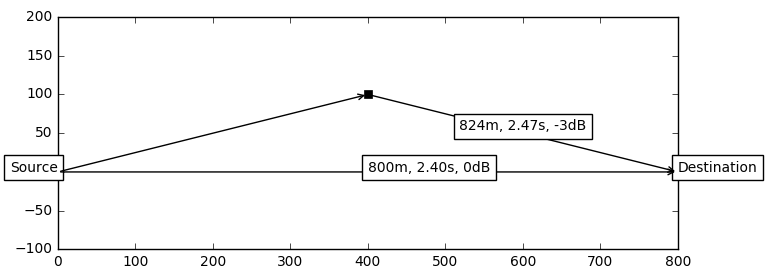

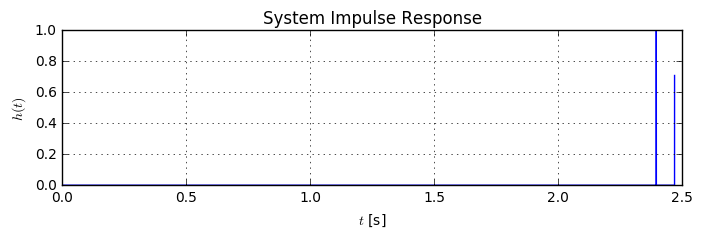

In [10]:
reflectors = [((400,100), -3)] # One reflector at x=400, y=100 with 3dB attenuation

plt.figure()
t, h = visualizeMultipath((0,0), (800,0), reflectors);  # source and destination are 800m apart.
plt.figure(figsize=(8,2))
plt.plot(t, h);
plt.xlabel('$t$ [s]'); plt.ylabel('$h(t)$'); plt.grid(True); plt.title("System Impulse Response");

We see two different paths from the source to the destination, where the second path has a smaller amplitude then the first one, since it attenuates the signal. Let's listen to the effect of this system to our sound samples:

In [11]:
audioSideBySide("Original Slap", Audio(data=data_slap, rate=rate), 
                "Received Slap", Audio(data=np.convolve(h, data_slap), rate=rate))
audioSideBySide("Original Morse", Audio(data=data_morse, rate=rate), 
                "Received Morse", Audio(data=np.convolve(h, data_morse), rate=rate))
audioSideBySide("Original Voice", Audio(data=data_voice, rate=rate), 
                "Received Voice", Audio(data=np.convolve(h, data_voice), rate=rate))
audioSideBySide("Original Music", Audio(data=data_music, rate=rate), 
                "Received Music", Audio(data=np.convolve(h, data_music), rate=rate))

Original Slap,Received Slap


Original Morse,Received Morse


Original Voice,Received Voice


Original Music,Received Music


First of all, we find that there is a delay of around 2.4s before the sound starts playing at the receiver side. Looking at the impulse response of the system, we can confirm this, since only after $2.4$ seconds $h(t)$ is non-zero. Second, for the slap sound we here a very short echo after. For the morse code, it seems as if just more encoded letters are received, as the sounds are not so clearly separated anymore. Already this little delay makes the decoding of this morse code challenging. For the voice transmission, it sounds as if there is some reverb in the signal (which is, as we know). For the music transmission, despite the initial delay, hardly an effect can be recognized. 

Now, lets add a second reflector, that creates a longer delay to our signal, but also attenuates it more. The impulse response and multipath diagram is shown below:

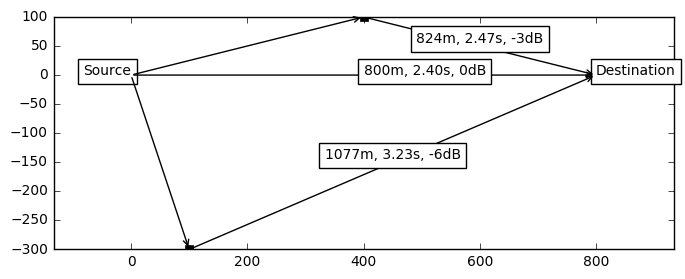

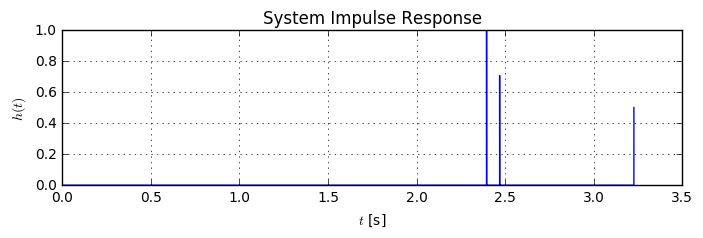

In [12]:
reflectors = [((400,100), -3),
              ((100, -300), -6)];

plt.figure()
t, h = visualizeMultipath((0,0), (800,0), reflectors);
plt.figure(figsize=(8,2))
plt.plot(t, h);
plt.xlabel('$t$ [s]'); plt.ylabel('$h(t)$'); plt.grid(True); plt.title("System Impulse Response");

As we see, there is an additional delay almost 0.8 seconds after the initial signal is received. Let's listen to the effect of this system to our audio samples:

In [13]:
audioSideBySide("Original Slap", Audio(data=data_slap, rate=rate), 
                "Received Slap", Audio(data=np.convolve(h, data_slap), rate=rate))
audioSideBySide("Original Morse", Audio(data=data_morse, rate=rate), 
                "Received Morse", Audio(data=np.convolve(h, data_morse), rate=rate))
audioSideBySide("Original Voice", Audio(data=data_voice, rate=rate), 
                "Received Voice", Audio(data=np.convolve(h, data_voice), rate=rate))
audioSideBySide("Original Music", Audio(data=data_music, rate=rate), 
                "Received Music", Audio(data=np.convolve(h, data_music), rate=rate))

Original Slap,Received Slap


Original Morse,Received Morse


Original Voice,Received Voice


Original Music,Received Music


For the slap, clearly a separate echo can be heard at after 3.2 seconds. For the morse transmission, this late echo completely destroys the signal and it'd be almost impossible to decode the data from listening to this signal. For the voice transmission, the voice can still be understood, but there is annoying echo which makes it harder to follow the speaker. For the music transmission, the second echo can be heard, but at the same time the music can still be recognized well. 

From these two different multipath systems, we can draw the following conclusions:

## Summary
> - **Multipath propagation** occurs, when a **signal** can reach its destination **over different paths**. Since each path has a different length, the signal experiences different delays at each path. At the destination, the sum of all delayed signal versions is received.
> - We can characterize the multipath propagation by the impulse response of the system. The **impulse response** tells us, at which time the different signals arrive.
> - **Multipath** can be heard as **echos or reverb** in an audio signal.
> - The severity of multipath highly depends on the signal. So, for example for voice transmission, an echo can be really annoying, whereas for the classical music, the music was still bearable even with late echos.